# W207 Final Project: OpenBarbell

## Part 2: Lifter Segmentation

## 9 August 2018

### Project Description

OpenBarbell is a device that measures key lifting metrics during a lifter's workout. Example metrics are weight (user entry), peak velocity, and rep time (device captured). These metrics can be used by a lifter to better understand and improve their performance. The goal of this project is to use the data produced by OpenBarbell to add greater intelligence to the user experience.

### Project Goals

 1. *Exercise classification*. Exercise name is an open field (lifters can enter whatever they want or nothing at all). However, it is one of the key variables to analyze lifter performance. Hence, we would like to build an algorithm to determine exercise for each set based on its characteristics (weight, range of motion, velocity etc.)
 2. *Lifter segmentation*. Can we create distinct groups of lifters based on their lifting characteristics for each exercise (velocity, range of motion, weight)? This would help create semi-customized training programs.

### Data and Source

 - [OpenBarbell Data](https://github.com/squatsandsciencelabs/OpenBarbell-V3/wiki/OpenBarbell-Data-Storage-Format) - the dataset is provided by Squats and Science Barbell, no NDA is required per owner (Jordan Berke)
 - [Project GitHub Repository](https://github.com/YuliaZamriy/W207_Group_Project)

### Team
 - Renzee Reyes
 - Tim Witthoefft
 - Jack Workman
 - Yulia Zamriy

### Part 1: Exercise Classification available here:
https://github.com/YuliaZamriy/W207_Group_Project/blob/master/w207_openbarbell_baseline_submission_v2.ipynb

# Notebook Outline

1. Import the Data
2. EDA for Lifter Segmentation
3. Data Preprocessing
4. Data Cleaning
5. Separate Data Into Train & Test Sets
6. Data Visualization
7. Hierarchical Clustering
8. Bringing It All Together
9. Example User

In [0]:
#!git clone https://github.com/YuliaZamriy/W207_Group_Project.git

In [0]:
#!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
#!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
#!apt-get update -qq 2>&1 > /dev/null
#!apt-get -y install -qq google-drive-ocamlfuse fuse
#from google.colab import auth
#auth.authenticate_user()
#from oauth2client.client import GoogleCredentials
#creds = GoogleCredentials.get_application_default()
#import getpass
#!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
#vcode = getpass.getpass()
#!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [1]:
#!mkdir -p drive
#!google-drive-ocamlfuse drive
#!pip install -q keras
## make sure Google Drive is mounted
!ls 

datalab  drive


In [0]:
import warnings
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import locale
import sys
import itertools
from mpl_toolkits.mplot3d import Axes3D
from locale import atof
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from scipy.stats import mode

%matplotlib inline
VERBOSE = True

In [0]:
warnings.filterwarnings(action='once')

In [111]:
# Jupyter viewing options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 500)

# suppress scientific float notation
np.set_printoptions(precision=5, suppress=True)

# 1. Import The Data

More information on the data and an initial EDA can be observed in our first notebook found here: https://github.com/YuliaZamriy/W207_Group_Project/blob/master/w207_openbarbell_baseline_submission_v2.ipynb


In [0]:
df = pd.read_csv("drive/Colab Notebooks/ob_data_w207_filtered.csv")

In [0]:
# csv_data_file = 'ob_data_w207_filtered.csv'
# zip_data_file = 'ob_data_w207_filtered.zip'

# locale.setlocale(locale.LC_NUMERIC, '')

# df = None
# if not os.path.exists(csv_data_file) and os.path.exists(zip_data_file):
#     zip_ref = zipfile.ZipFile(zip_data_file, 'r')
#     zip_ref.extractall()
#     zip_ref.close()
# if os.path.exists(csv_data_file):
#     df = pd.read_csv(csv_data_file)
#     # -- pandas supposedly coverts '7,39' to '7.39' with decimal arg but it didn't work
#     #df = pd.read_csv(csv_data_file, decimal='.')
# else:
#     raise Exception('Data file not found! {0}'.format(csv_data_file))

# 2. EDA for Lifter Segmentation

### Potential features to consider for lifter segmentation:

 Lifting-related:
 
 - `rpe_num`: uses RPE or not
 - `weight_lbs`
 - `RepCount`: values start from 0 (counts of 1); higher repper vs. low
 - `ROM`
 - `AvgVel`
 - `PeakVel`
 - `PeakVelLoc`
 - `RepDur`
 - `PeakAccel`


User-related:

 - `initialStartTime` / `startTime` / `time`
 - `tags`: tagger or not
 - `workoutID`: number of unique workouts
 - `hardware`:  two values: (ios, android)
 - `deviceName`/`deviceIdentifier`:  how many devices is using
 
 
 ### Potential lifter identifiers:
 
 - Primary: `userID`
 - Secondary:`exercise_clean`


In [0]:
def check_frequency(feature):
    counts = feature.value_counts()
    print(f"\n{feature.name} has {counts.shape[0]} unique values")
    print("Top 10 values are:")
    if counts.shape[0] > 10:
          print(counts[:10])
    else:
          print(counts)

In [115]:
check_frequency(df['appVersion'])


appVersion has 24 unique values
Top 10 values are:
3.2.3    67488
3.3.1    65767
3.0.3    30518
3.3.0    30365
1.5.2    13119
3.1.5    10387
3.2.0     9151
3.0.0     8926
3.1.4     6909
1.5.3     6842
Name: appVersion, dtype: int64


In [116]:
ls_discrete_features = ['hardware', 'rpe_num', 'RepCount', 'tags', 'deviceName']
for v in ls_discrete_features:
    check_frequency(df[v])


hardware has 2 unique values
Top 10 values are:
ios        189386
android     89821
Name: hardware, dtype: int64

rpe_num has 45 unique values
Top 10 values are:
8.0     21131
7.0     21067
6.0     14131
5.5     12783
7.5      9561
9.0      8933
8.5      7849
6.5      6294
10.0     3354
Name: rpe_num, dtype: int64

RepCount has 115 unique values
Top 10 values are:
0.0     66760
1.0     61538
2.0     52633
3.0     35216
4.0     26591
5.0     15191
6.0      9561
7.0      7190
8.0      4404
9.0      3315
10.0     1801
Name: RepCount, dtype: int64

tags has 4097 unique values
Top 10 values are:
[]              148087
['Belt']          5788
['warmup']        3570
['belt']          2629
['Duffalo']       1836
['beltless']      1691
['Beltless']      1516
['warm up']       1422
['no belt ']      1405
['Speed']         1398
Name: tags, dtype: int64

deviceName has 343 unique values
Top 10 values are:
OB 3248    9059
OB 6666    6897
OB 2257    6748
OB 3434    6059
OB 3302    5812
OB 3162    56

In [117]:
def get_descr(data, features=None):
    if features is None:
        features = data.columns
    data_descr = data[features].describe()
    pct_missing = pd.Series(100-np.around(data_descr.loc['count',]/data.shape[0]*100,2))
    pct_missing.name = 'pct_missing'
    pct_zero = pd.Series([100*sum(data[v] == 0)/data.shape[0] for v in features])
    pct_zero.name = 'pct_zeros'
    pct_zero.index = pct_missing.index
    data_descr = data_descr.append(pct_missing)
    data_descr = data_descr.append(pct_zero)
    return data_descr
  
#ls_cont_features = ['rpe_num', 'RepCount', 'weight_lbs', 'AvgVel',
#                    'ROM', 'PeakVel', 'PeakVelLoc', 'RepDur', 'PeakAccel']
ls_cont_features = ['weight_lbs', 'AvgVel', 'PeakVel']

get_descr(df, ls_cont_features)

,weight_lbs,AvgVel,PeakVel
count,283142.000000,292891.000000,292910.000000
mean,235.271909,0.479184,0.771857
std,105.251502,0.223486,0.377337
min,0.000000,0.000000,0.000000
25%,165.000000,0.320720,0.483974
50%,225.000000,0.435733,0.718287
75%,300.000000,0.591369,0.976293
max,1000.000000,2.960175,5.560000
pct_missing,3.330000,0.010000,0.000000
pct_zeros,0.130415,0.001366,0.001366


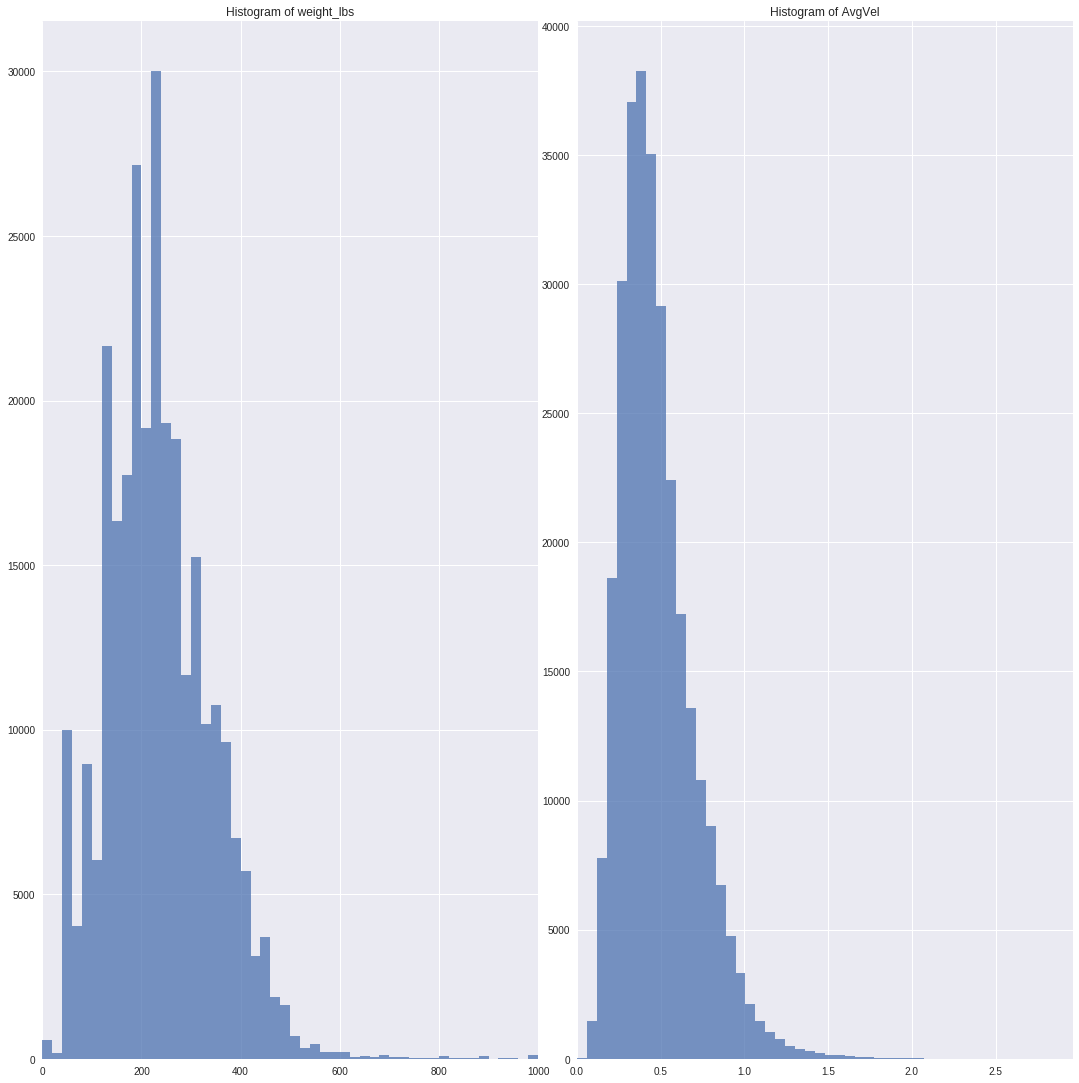

In [118]:
def plot_multi_hist(data, features):
  nrows = len(features)//2
  ncols = min(len(features), 2)
  fig, axs = plt.subplots(nrows, ncols, figsize=(15,15))
  fig.tight_layout()
  for ax, index in zip(axs.ravel(), range(len(features))):
    bins = 50
    adj = 10
    xmin = np.min(data[features[index]])
    xmax = np.max(data[features[index]])
    x99 = np.nanpercentile(data[features[index]], 99)
    if xmax/x99 > adj:
      xmax = x99/2
      bins *= adj*5
    ax.hist(data[features[index]].dropna(), bins, alpha=0.75)
    ax.set_title(f'Histogram of {features[index]}')
    ax.set_xlim([xmin, xmax])
    ax.grid(True)
  plt.show()
  
plot_multi_hist(df, ls_cont_features)

## Figuring out lifter id -- jack: is this part of the EDA? I don't think we use any part of this code later in the notebook

In [0]:
def feature_descr(feature):
  print(f"{feature.name} Summary:")
  print(feature.describe())
  
  print(f"\nLow occurrence for {feature.name}:")
  for i in range(1, 10):
    print(f"There are {sum(feature==i)} unique values with {i} observation(s)")
  
  print(f"\n{feature.name} Histogram:")
  xmin, xmax = np.min(feature), np.nanpercentile(feature, 99)
  plt.hist(feature, 100, facecolor = 'g', alpha = 0.75)
  plt.xlim([xmin, xmax])
  plt.show()

In [120]:
userID_count = df['userID'].value_counts()
userID_count.shape

(460,)

userID Summary:
count      460.000000
mean       636.760870
std       1257.673288
min          1.000000
25%         27.750000
50%        111.500000
75%        571.250000
max      10568.000000
Name: userID, dtype: float64

Low occurrence for userID:
There are 2 unique values with 1 observation(s)
There are 4 unique values with 2 observation(s)
There are 8 unique values with 3 observation(s)
There are 6 unique values with 4 observation(s)
There are 6 unique values with 5 observation(s)
There are 6 unique values with 6 observation(s)
There are 5 unique values with 7 observation(s)
There are 11 unique values with 8 observation(s)
There are 2 unique values with 9 observation(s)

userID Histogram:


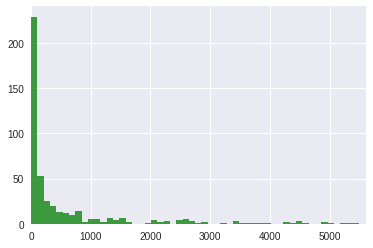

In [121]:
feature_descr(userID_count)

In [0]:
df_grouped_wourkout = df.groupby(['userID', 'workoutID'])
df_grouped_wourkout = df_grouped_wourkout.size()
df_grouped_wourkout.name = 'userID-workoutID count'

userID-workoutID count Summary:
count    11034.000000
mean        26.546130
std         21.903629
min          1.000000
25%         10.000000
50%         22.000000
75%         36.000000
max        345.000000
Name: userID-workoutID count, dtype: float64

Low occurrence for userID-workoutID count:
There are 261 unique values with 1 observation(s)
There are 314 unique values with 2 observation(s)
There are 430 unique values with 3 observation(s)
There are 302 unique values with 4 observation(s)
There are 236 unique values with 5 observation(s)
There are 302 unique values with 6 observation(s)
There are 172 unique values with 7 observation(s)
There are 228 unique values with 8 observation(s)
There are 323 unique values with 9 observation(s)

userID-workoutID count Histogram:


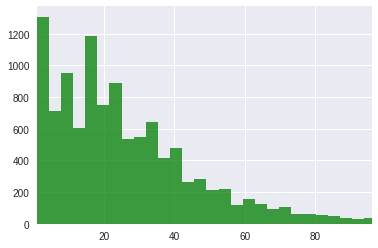

In [123]:
feature_descr(df_grouped_wourkout)

In [124]:
df_grouped_wourkout.loc[df_grouped_wourkout == max(df_grouped_wourkout)]

userID                    workoutID                           
5aa35456880e87b3f32ddf7c  c1d046a3-bf4e-4ba8-a43a-2568a3b21620    345
Name: userID-workoutID count, dtype: int64

In [125]:
# this is account used for S&S internal study
# we might need to exclude it (multiple people)
df_study = df.loc[df['userID'] == '5aa35456880e87b3f32ddf7c']
df_study.shape

(3506, 45)

In [126]:
df_grouped_wourkout.sort_values(ascending=False)[:10]

userID                    workoutID                           
5aa35456880e87b3f32ddf7c  c1d046a3-bf4e-4ba8-a43a-2568a3b21620    345
                          7464e24b-25af-4435-a29e-6735cf838dd4    305
                          870ca10a-1f71-4cbf-a3f8-6ef0f0cc56c1    281
                          21b51e5a-6a80-48d8-827b-b2309f4cd405    201
5a43c264fd4ef00da9b8ccce  3388ac48-1f31-46c1-88db-d82b72209a01    184
5a15b00e05cbc9b8ef26ac59  4d2ad298-337d-46bb-bd46-49f45d42158e    183
59debbdd05cbc9b8ef26ac1c  dbc82f2e-0401-43c6-9c9a-afc52434f724    176
5aa35456880e87b3f32ddf7c  908fe3e3-34c9-4c2f-8ae4-7d22354e2b9b    175
589d473d6ca711fcd8cb7af9  93a67da5-12c4-42d1-a067-ca77e04af8ab    174
5a43c264fd4ef00da9b8ccce  426232d3-7874-4c44-9a5a-6e9b860bbf1c    151
Name: userID-workoutID count, dtype: int64

# 3. Data Preprocessing

Each row in the initial dataset corresponds to one lift performed by a user. Lifters usually perform multiple lifts in a set and multiple sets in a workout.

In this section, we attempt to summarize the characterization of each user's squat, bench, or deadlift by grouping and aggregating certain features.

In [0]:
def data_preprocessing(data):
    data = data.assign(RepCount = df['RepCount'] + 1)
    return data

In [0]:
def select_exercise(data, exercise, exercise_col='exercise_clean', verbose=False):
    exercise_only = data.loc[data['exercise_clean'].isin([exercise])]
    exercise_only = exercise_only.drop('exercise_clean', axis=1)
    
    if verbose:
        print('Selected Exercise "{0}": shape_before={1}, shape_after={2}'.format(exercise, data.shape, exercise_only.shape))
        
    return exercise_only

In [0]:
def group_data(data, group_cols, feature_cols, verbose=False):
    data = data[group_cols + feature_cols].groupby(group_cols)

    return data

In [0]:
def aggregate_data(data, aggregator_funcs, verbose=False):
    data_aggd = data.agg(aggregator_funcs)
    data_aggd.columns = data_aggd.columns.map('_'.join)
    features = list(data_aggd.columns)
    if verbose:
        print('Aggregated Data: shape={0}'.format(data_aggd.shape))
        print('Features={0}'.format(features))
        
    return data_aggd, features

In [0]:
def group_and_aggregate_data(data, group_cols, feature_cols, aggregator_funcs, verbose=False):
    grouped = group_data(data, group_cols, feature_cols, verbose)
    aggregated, features = aggregate_data(grouped, aggregator_funcs, verbose)
    
    grp_and_aggd = aggregated.reset_index()
    
    # we do not need groupby columns anymore
    grp_and_aggd = grp_and_aggd.drop(group_cols, axis=1)
    
    if verbose:
        print('Grouped and Aggregated Data: shape={0}'.format(grp_and_aggd.shape))

    return grp_and_aggd, features   

In [132]:
df_proc = data_preprocessing(df)

exercise = 'bench'
df_exercise = select_exercise(df_proc, exercise, verbose=VERBOSE)

Selected Exercise "bench": shape_before=(292910, 45), shape_after=(94640, 44)


In [133]:
feature_cols = ['weight_lbs', 'RepDur', 'AvgVel']
group_cols = ['workoutID']
aggregator_funcs = [np.mean]

df_grouped, final_features = group_and_aggregate_data(df_exercise, group_cols, feature_cols, aggregator_funcs, verbose=VERBOSE)

Aggregated Data: shape=(4320, 3)
Features=['weight_lbs_mean', 'RepDur_mean', 'AvgVel_mean']
Grouped and Aggregated Data: shape=(4320, 3)


In [134]:
df_grouped.head()

,weight_lbs_mean,RepDur_mean,AvgVel_mean
0,NaN,5.763700e+05,0.763544
1,NaN,1.821274e+06,0.211938
2,264.554400,9.614565e+05,0.332449
3,330.693000,5.424553e+05,0.799164
4,246.058824,1.600570e+06,0.228163


# 4. Data Cleaning

Two issues arise with this dataset that must be resolved before clustering. The first is missing data which we handle with sklean's Imputer. The second is standardizing feature values. This we accomplish with sklearn's RobustScaler class.

## 4.1 Handle Missing Data

In [0]:
def impute_data(data, verbose=False):
    """
    Args:
        data: feature dataset used to fit and apply impute calculations
    
    Returns:
    """
    
    data_im = preprocessing.Imputer(strategy='mean').fit_transform(data)
    data_im = pd.DataFrame(data_im, index=data.index, columns=data.columns)
    
    if verbose:
        print(f"Dataset mean before impute: {round(data.mean().mean(),2)}")
        print(f"Number of missing values: {data.isnull().sum().sum()}")
        print(f"Dataset mean after impute: {round(data.mean(),2)}")
        print(f"Number of missing after impute: {np.isnan(data).sum()}")
    
    return data_im

In [136]:
df_imputed = impute_data(df_grouped, verbose=VERBOSE)

Dataset mean before impute: 344450.4
Number of missing values: 158
Dataset mean after impute: weight_lbs_mean        209.14
RepDur_mean        1033141.67
AvgVel_mean              0.38
dtype: float64
Number of missing after impute: weight_lbs_mean    102
RepDur_mean         56
AvgVel_mean          0
dtype: int64


## 4.2 Standardize Features

In [0]:
def standardize_data(data, verbose=False):
    """
    Standardize input dataset and apply it to the second input dataset
    
    Args:
        data: feature dataset used to fit and apply standardization
    
    Returns:
        standardized dataset
    """
    
    scaler = preprocessing.RobustScaler()
    scaled_data = scaler.fit_transform(data)
    #scaled_data = preprocessing.StandardScaler().fit_transform(data)
    data_std = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)
 
    if verbose:
        print(f"\nMeans of standardized features:\n {np.around(np.mean(data_std, axis = 0),2)}")
        print(f"Std dev of standardized features:\n {np.around(np.std(data_std, axis = 0),2)}")
    
    return data_std, scaler

In [152]:
df_clean, scaler = standardize_data(df_imputed, verbose=VERBOSE)
df_clean.head()


Means of standardized features:
 weight_lbs_mean    0.03
RepDur_mean        0.04
AvgVel_mean        0.25
dtype: float64
Std dev of standardized features:
 weight_lbs_mean    0.87
RepDur_mean        0.84
AvgVel_mean        0.91
dtype: float64


,weight_lbs_mean,RepDur_mean,AvgVel_mean
0,0.033405,-1.038387,2.168295
1,0.033405,1.894348,-0.605647
2,0.705541,-0.131204,0.000386
3,1.507751,-1.118283,2.347425
4,0.481204,1.374415,-0.524054


# 5. Separate Data Into Train & Test Sets

In [139]:
#df_train, df_test = train_test_split(df_grouped_full.loc[df_grouped_full['exercise_clean'].isin(["squat", "bench", "deadlift"])],
df_train, df_test = train_test_split(df_clean,
                                     test_size=0.1,
                                     shuffle=True,
                                     random_state=5)

print(df_train.shape)
print(df_test.shape)

(3888, 3)
(432, 3)


In [140]:
#features_to_plot = ['weight_lbs_mean', 'AvgVel_mean', 'PeakVelLoc_mean',
#                    'ROM_mean', 'PeakVel_mean', 'RepDur_mean']
#features_to_plot = ['weight_lbs_mean', 'AvgVel_mean']
df_train.head()

,weight_lbs_mean,RepDur_mean,AvgVel_mean
3176,1.644897,0.769186,-0.134647
3043,-1.079900,-0.798189,0.620378
47,-0.571287,-0.486789,0.257656
3817,0.883810,2.092054,-1.104793
2647,-0.811660,-1.157170,1.660406


In [37]:
get_descr(df_train, final_features)

,weight_lbs_mean,RepDur_mean,AvgVel_mean
count,3888.000000,3888.000000,3888.000000
mean,0.031443,0.037557,0.250280
std,0.855444,0.834210,0.899610
min,-2.289378,-2.396196,-1.671453
25%,-0.485779,-0.516635,-0.352298
50%,0.000544,0.001190,-0.001055
75%,0.491618,0.484796,0.647024
max,5.919909,6.407112,7.437647
pct_missing,0.000000,0.000000,0.000000
pct_zeros,0.000000,0.000000,0.000000


# 6. Data Visualization - Jack: still needed? should we move to EDA section?



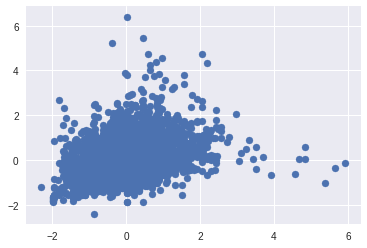

In [40]:
plt.scatter(df_train[final_features[0]], df_train[final_features[1]])
plt.show()

In [0]:
cmaps = ['YlGn', 'RdPu', 'OrRd', 'Purples', 'YlGnBu', 'Reds']

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


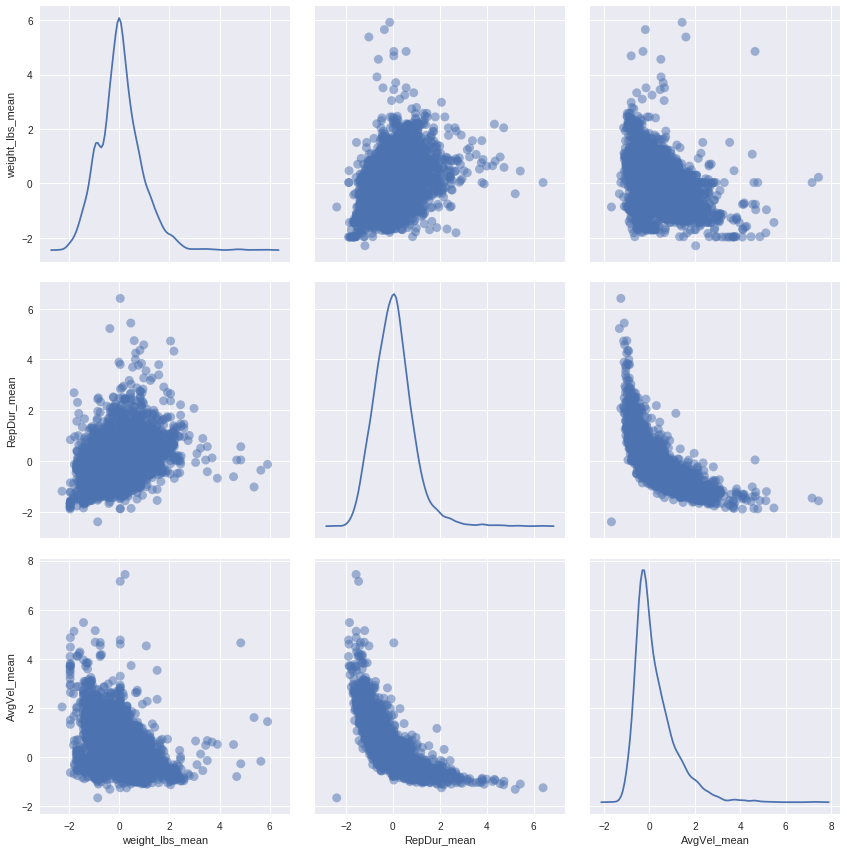

In [42]:
# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
sns.pairplot(df_train, diag_kind='kde',
            plot_kws={'alpha': 0.5, 's': 80, 'edgecolor': 'none'},
            size=4, palette='hls')

In [0]:
def plot_exercise_grid(data, exercise, features_to_include, category='exercise_clean'):
    
    grid = sns.PairGrid(data=data[data['exercise_clean'] == exercise], 
                        hue = category, 
                        vars = features_to_include, 
                        size = 4,
                        palette = 'hls',
                        hue_kws={"cmap":cmaps})
    # Map a scatter plot to the upper triangle
    grid = grid.map_upper(plt.scatter)
    # Map a histogram to the diagonal
    grid = grid.map_diag(sns.kdeplot, shade=True)
    # Map a density plot to the lower triangle
    # This gives a lot of innocuous warnings if warnings are not disabled
    grid = grid.map_lower(sns.kdeplot, shade=True, shade_lowest=False)    
    grid = grid.add_legend()

In [0]:
plot_exercise_grid(df_train, 'bench', list(df_train)[:-2])

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


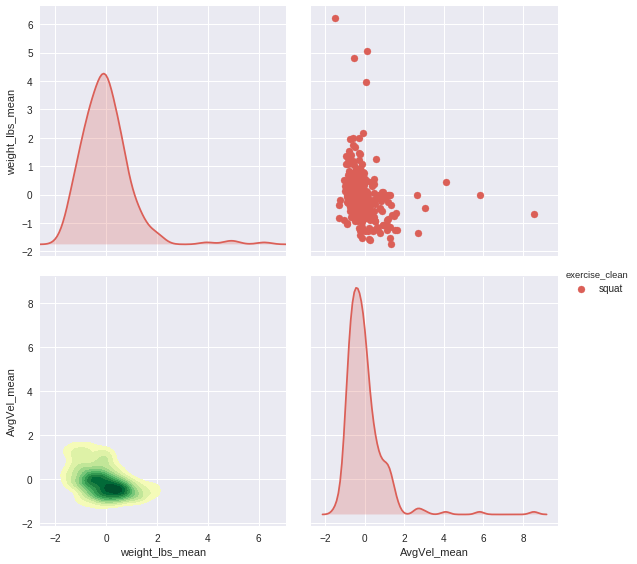

In [100]:
plot_exercise_grid(df_train_pr, 'squat', list(df_train_pr)[:-2])

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


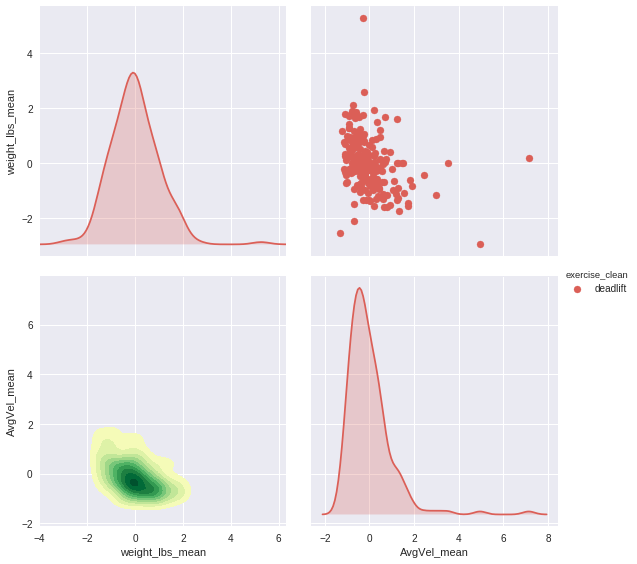

In [101]:
plot_exercise_grid(df_train_pr, 'deadlift', list(df_train_pr)[:-2])

# 7. Hierarchical Clustering

All credit goes to:
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [0]:
def plot_feature_grid(data, features_to_include):
    
    grid = sns.PairGrid(data = data, 
                        vars = features_to_include, 
                        size = 4,
                        palette = 'hls',
                        hue_kws={"cmap":cmaps})
    # Map a scatter plot to the upper triangle
    grid = grid.map_upper(plt.scatter)
    # Map a histogram to the diagonal
    grid = grid.map_diag(sns.kdeplot, shade=True)
    # Map a density plot to the lower triangle
    # This gives a lot of innocuous warnings if warnings are not disabled
    grid = grid.map_lower(sns.kdeplot, shade=True, shade_lowest=False)    
    grid = grid.add_legend()

def plot_dendogram(Z, max_d):
    plt.figure(figsize=(25, 10))
    plt.title(f"Hierarchical Clustering Dendrogram")
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        leaf_rotation=10.,  # rotates the x axis labels
        leaf_font_size=12.,  # font size for the x axis labels
        color_threshold = max_d
    )
    plt.axhline(y=max_d, c='k', ls='--')
    plt.show()
    
def make_clusters(data, cutoff, link='ward', dist='euclidean', verbose=False):
    X = data.values 
    Z = linkage(X, link)
    c, coph_dists = cophenet(Z, pdist(X, dist))
    max_d = cutoff*max(Z[:,2])
    
    #clusters = pd.DataFrame(fcluster(Z, max_d, criterion='distance'), columns=["Cluster"])
    clusters = fcluster(Z, max_d, criterion='distance')
    #clusters = pd.concat([IDS, clusters], axis=1)
    
    if verbose:
      print('Number of Clusters = {0}'.format(len(np.unique(clusters))))
      print('c: {0}'.format(c))
      print('coph_dists: {0}'.format(coph_dists))
      print('max_d: {0}'.format(max_d))

    return Z, max_d, clusters
  
def visualize_clusters_2d(X, Y, colors, title):
    plt.scatter(X, Y, c=colors, cmap='prism')
    plt.title(title)
    plt.show()

def visualize_clusters_3d(X, Y, Z, colors, title):
    # http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html
    fig = plt.figure(1, figsize=(8, 6))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    plt.cla()
    
    ax.scatter(X, Y, Z, c=colors, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])

    plt.title(title)
    plt.show()
    
def visualize_clusters(data, features, clusters, title=""):
    if len(features) == 2:
        visualize_clusters_2d(data[features[0]], data[features[1]], clusters.ravel(), title=title)
    elif len(features) == 3:
        visualize_clusters_3d(data[features[0]], data[features[1]], data[features[2]], clusters.ravel(), title=title)
    elif len(features) > 3:
        print('Dimensions > 3. Running PCA with n=3.')
        pca = PCA(n_components=3)
        pca.fit(df_train)
        pca_train = pd.DataFrame(pca.transform(df_train))
        visualize_clusters_3d(pca_train[0], pca_train[1], pca_train[2], clusters.ravel(), title=title)
        
    return


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:590: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f2e102d3860> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


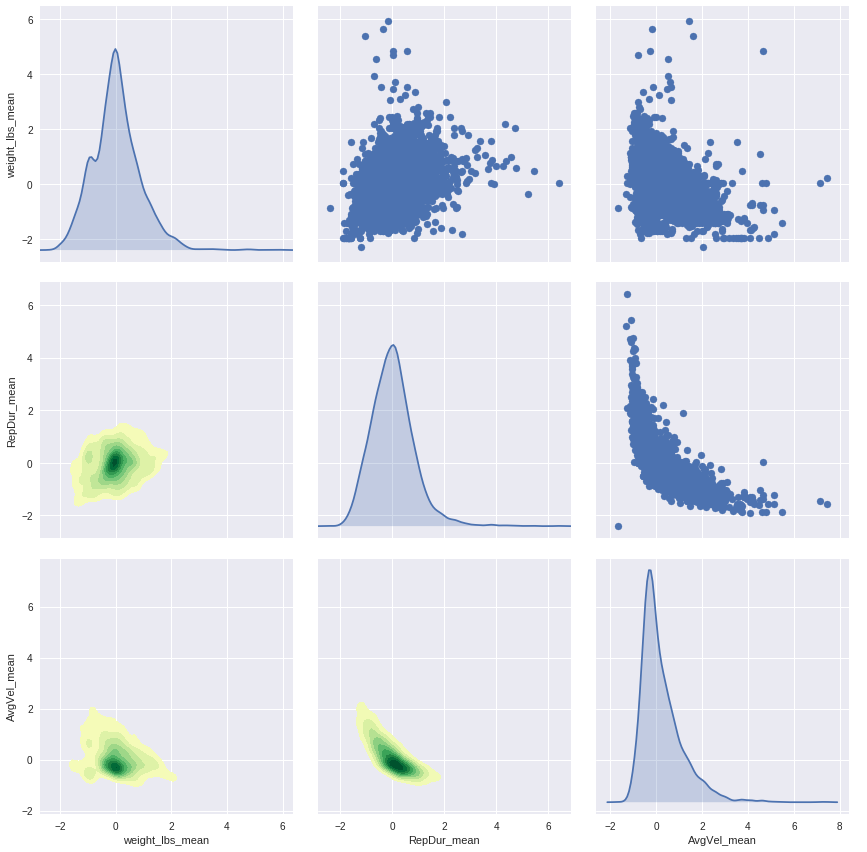

In [49]:
plot_feature_grid(df_train, final_features)

In [69]:
Z, max_d, clusters = make_clusters(df_train, 0.3, verbose=VERBOSE)
_, _, clusters_test = make_clusters(df_test, 0.3)  # for use in section Example User below

Number of Clusters = 6
c: 0.48814391963429454
coph_dists: [80.6445  48.09658 14.00074 ... 80.6445  80.6445  48.09658]
max_d: 24.193350435915498


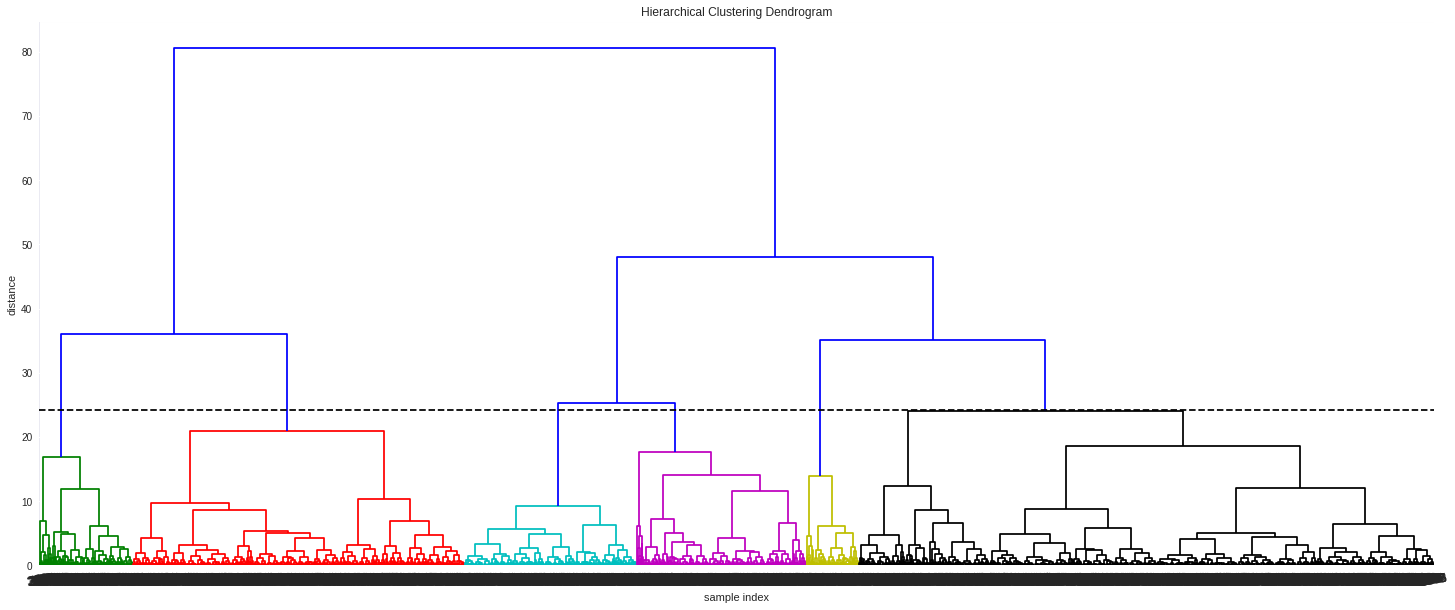

In [51]:
plot_dendogram(Z, max_d)

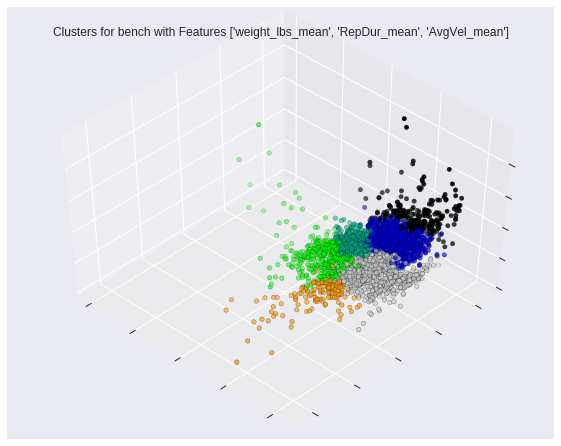

In [62]:
visualize_clusters(df_train, final_features, clusters, title='Clusters for {0} with Features {1}'.format(exercise, final_features))

# 8. Bringing It All Together

In [0]:
#@title Select Groupby Columns
userID = False  #@param {type:"boolean"}
workoutID = True  #@param {type:"boolean"}

# Form - Groups
group_cols = list()
if userID:
    group_cols.append('userID')
if workoutID:
    group_cols.append('workoutID')

In [0]:
#@title Select Exercise
exercise = "bench" #@param ["squat", "bench", "deadlift"]

In [0]:
#@title Select Feature Columns
rpe_num = False  #@param {type:"boolean"}
weight_lbs = True  #@param {type:"boolean"}
RepCount = False  #@param {type:"boolean"}
ROM = False  #@param {type:"boolean"}
AvgVel = True  #@param {type:"boolean"}
PeakVel = False  #@param {type:"boolean"}
PeakVelLoc = False  #@param {type:"boolean"}
RepDur = True  #@param {type:"boolean"}
PeakAccel = False  #@param {type:"boolean"}

# Form - Features
feature_cols = list()
if rpe_num:
    feature_cols.append('rpe_num')
if weight_lbs:
    feature_cols.append('weight_lbs')
if RepCount:
    feature_cols.append('RepCount')
if ROM:
    feature_cols.append('ROM')
if AvgVel:
    feature_cols.append('AvgVel')
if PeakVel:
    feature_cols.append('PeakVel')
if PeakVelLoc:
    feature_cols.append('PeakVelLoc')
if RepDur:
    feature_cols.append('RepDur')
if PeakAccel:
    feature_cols.append('PeakAccel')

In [0]:
#@title Select Feature Aggregators
np_mean = True  #@param {type:"boolean"}
np_min = False  #@param {type:"boolean"}
np_max = False  #@param {type:"boolean"}
np_std = False  #@param {type:"boolean"}

# Form - Aggs
aggregator_funcs = list()
if np_mean:
  aggregator_funcs.append(np.mean)
if np_min:
  aggregator_funcs.append(np.min)
if np_max:
  aggregator_funcs.append(np.max)
if np_std:
  aggregator_funcs.append(np.std)

In [0]:
#@title Hierarchical Clustering Setup

cutoff = 0.2  #@param {type:"slider", min:0, max:1, step:0.01}
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
linkage_algo = 'ward'  #@param ["ward", "single", "complete", "average", "weighted", "centroid"]
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
distance_algo = 'euclidean'  #@param ["ward", "minkowski", "cityblock", "euclidean", "seuclidean", "sqeuclidean", "cosine", "correlation", "hamming"]

In [0]:
### Jack's first settings
#exercise = 'bench'
#feature_cols = ['weight_lbs', 'RepDur', 'AvgVel']
#group_cols = ['workoutID']
#aggregator_funcs = [np.mean]
#cutoff = 0.48

def lifter_segmentation(data, exercise, group_cols, feature_cols, aggregator_funcs, cutoff, linkage_algo, distance_algo, verbose=False):
    df_exercise = select_exercise(data, exercise, verbose=verbose)
    print()
    df_grouped, final_features = group_and_aggregate_data(df_exercise, group_cols, feature_cols, aggregator_funcs, verbose=verbose)
    print()
    df_imputed = impute_data(df_grouped, verbose=verbose)
    print()
    df_clean, _ = standardize_data(df_imputed, verbose=VERBOSE)
    print()
    df_train, df_test = train_test_split(df_clean, test_size=0.1, shuffle=True, random_state=5)
    print()
    Z, max_d, clusters = make_clusters(df_train, cutoff, link=linkage_algo, dist=distance_algo, verbose=VERBOSE)
    print()
    #plot_dendogram(Z, max_d)  # comment out for speed-up    
    print()
    visualize_clusters(df_train, final_features, clusters, title="Clusters for {0} with Features {1}".format(exercise, final_features))

    return

Selected Exercise "bench": shape_before=(292910, 45), shape_after=(94640, 44)

Aggregated Data: shape=(4320, 3)
Features=['weight_lbs_mean', 'RepDur_mean', 'AvgVel_mean']
Grouped and Aggregated Data: shape=(4320, 3)

Dataset mean before impute: 344450.4
Number of missing values: 158
Dataset mean after impute: weight_lbs_mean        209.14
RepDur_mean        1033141.67
AvgVel_mean              0.38
dtype: float64
Number of missing after impute: weight_lbs_mean    102
RepDur_mean         56
AvgVel_mean          0
dtype: int64


Means of standardized features:
 weight_lbs_mean    0.03
RepDur_mean        0.04
AvgVel_mean        0.25
dtype: float64
Std dev of standardized features:
 weight_lbs_mean    0.87
RepDur_mean        0.84
AvgVel_mean        0.91
dtype: float64


Number of Clusters = 11
c: 0.48814391963429454
coph_dists: [80.6445  48.09658 14.00074 ... 80.6445  80.6445  48.09658]
max_d: 16.128900290610332




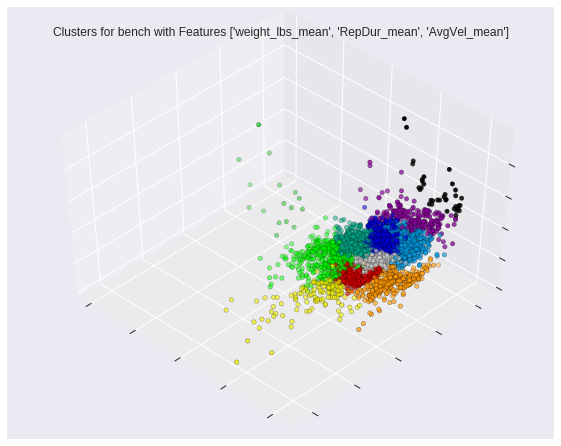

In [67]:
lifter_segmentation(df, exercise, group_cols, feature_cols, aggregator_funcs, cutoff, linkage_algo, distance_algo, VERBOSE)

# 9. Example User

Now that we have our clusters, we can demonstrate how our users will benefit. Here, we fit a simple K Nearest Neighbors classifier to our now labeled data. We then select a random user from the dataset and use the trained KNN model to identify which cluster they belong to. From there, we present the user with useful information about other lifters in their cluster that they can compare themselves to.

In [0]:
KnnClsf = KNeighborsClassifier(len(np.unique(clusters)))
KnnClsf = KnnClsf.fit(df_train, clusters)
#accuracy = KnnClsf.score(df_test, clusters_test)
#print(accuracy)

In [155]:
df_users, _ = group_and_aggregate_data(df, ['userID'], feature_cols, aggregator_funcs, verbose=False)
example_user = pd.DataFrame(df_users.iloc[100]).T

print('The Example User:\n')
print(example_user)

user_cluster = KnnClsf.predict(example_user)[0]

print('\nPredicted Cluster =\n\n{0}'.format(user_cluster))

print('\nUseful info about Cluster {0}:\n'.format(user_cluster))

df_cluster = df_train.copy(deep=True)
df_cluster['cluster'] = clusters
df_cluster = df_cluster[df_cluster['cluster'] == 5]

#print('Weight (lbs) Max:  {0}'.format(scaler.inverse_transform(df_train['weight_lbs_mean'].max())))
print('Weight (lbs) Max:  {0}'.format(df_train['weight_lbs_mean'].max()))
print('             Min:  {0}'.format(df_train['weight_lbs_mean'].min()))
print('             Mean: {0}'.format(df_train['weight_lbs_mean'].mean()))
print('Avg Velocity Max:  {0}'.format(df_train['AvgVel_mean'].max()))
print('             Min:  {0}'.format(df_train['AvgVel_mean'].min()))
print('             Mean: {0}'.format(df_train['AvgVel_mean'].mean()))

# todo - reverse scaling or start anew


The Example User:

     weight_lbs_mean   RepDur_mean  AvgVel_mean
100            185.0  1.219762e+06     0.514888

Predicted Cluster =

5

Useful info about Cluster 5:

Weight (lbs) Max:  5.919908758828533
             Min:  -2.2893781076808875
             Mean: 0.03144260076395494
Avg Velocity Max:  7.437646639569304
             Min:  -1.671453175279002
             Mean: 0.25027955688560005


# WIP

Clustering for bench
Clustering dataset shape: (3888, 2)


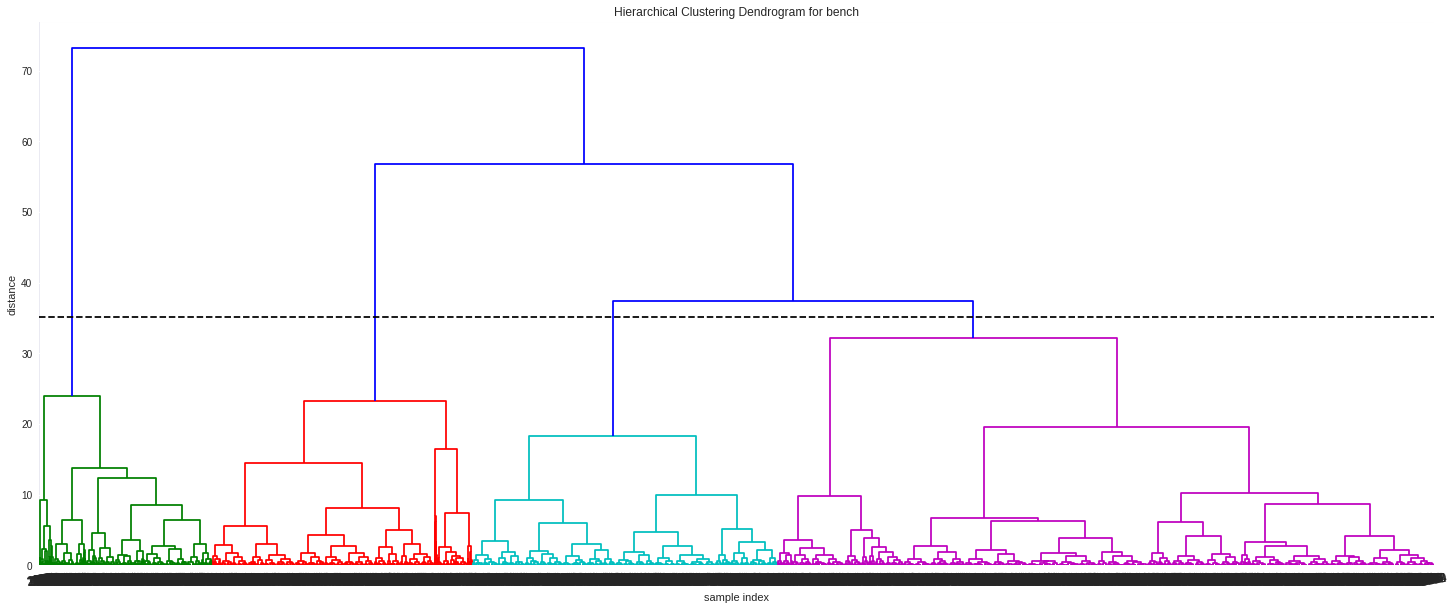


Cluster has 4 unique values
Top 10 values are:
4    1830
3     852
2     722
1     484
Name: Cluster, dtype: int64
Clustering for squat
Clustering dataset shape: (0, 2)


ValueError: ignored

In [336]:
def make_clusters(data, exercise, features, cutoff, link='ward', dist='euclidean'):
    
    print("="*150)
    print(f"Clustering for {exercise}")
    IDS = data[data['exercise_clean'] == exercise][grouping_vars]
    # resetting the index to ensure proper merge with clusters
    IDS.reset_index(drop=True, inplace=True)
    
    X = data[data['exercise_clean'] == exercise][features].values
    print(f"Clustering dataset shape: {X.shape}")
    
    Z = linkage(X, link)
    c, coph_dists = cophenet(Z, pdist(X, dist))
    
    max_d = cutoff*max(Z[:,2])
    
    plt.figure(figsize=(25, 10))
    plt.title(f"Hierarchical Clustering Dendrogram for {exercise}")
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        leaf_rotation=10.,  # rotates the x axis labels
        leaf_font_size=12.,  # font size for the x axis labels
        color_threshold = max_d
    )
    plt.axhline(y=max_d, c='k', ls='--')
    plt.show()  
    
    clusters = pd.DataFrame(fcluster(Z, max_d, criterion='distance'), columns=["Cluster"])
    clusters = pd.concat([IDS, clusters], axis=1)
    check_frequency(clusters["Cluster"])
    
    return clusters

#features_for_clustering = ['weight_lbs_mean', 'AvgVel_mean', 'PeakVelLoc_mean',
#                    'ROM_mean', 'PeakVel_mean', 'RepDur_mean',
#                   'AvgVel_std', 'PeakVel_std', ]
features_for_clustering = ['weight_lbs_mean', 'AvgVel_mean']

bench_clusters = make_clusters(df_train_pr, 'bench', features_for_clustering, 0.48)
squat_clusters = make_clusters(df_train_pr, 'squat', features_for_clustering, 0.48)
deadlift_clusters = make_clusters(df_train_pr, 'deadlift', features_for_clustering, 0.48)

In [106]:
outlier_ids = set(list(bench_clusters[bench_clusters['Cluster']==2]['userID']) + 
                  list(squat_clusters[squat_clusters['Cluster']==1]['userID']) +
                  list(deadlift_clusters[deadlift_clusters['Cluster'].isin([1,3])]['userID']))
len(outlier_ids)

212

In [107]:
# df_train_hc = df_train[~df_train['userID'].isin(outlier_ids)]
users = pd.DataFrame(df_train['userID'].unique(), columns = ['userID'])
users = (users.merge(bench_clusters, on='userID', how='left')
             .merge(squat_clusters, on='userID', how='left')
             .merge(deadlift_clusters, on='userID', how='left'))
users.drop(['exercise_clean_x', 'exercise_clean_y', 'exercise_clean'], 
           axis = 1, inplace=True)
users.columns = ['userID', 'Cluster_bench', 'Cluster_squat', 'Cluster_deadlift']
users.fillna(0, inplace=True)
# excluding clusters with outliers
users = users[~users['userID'].isin(outlier_ids)]
users.head(5)

,userID,Cluster_bench,Cluster_squat,Cluster_deadlift
8,5aa55d9a880e87b3f32ddf80,4.0,0.0,0.0
9,59bfc20a85ea1c6b42e4b256,0.0,2.0,0.0
13,58a1f0df6ca711fcd8cb7b0e,4.0,2.0,0.0
17,59d8e89d85ea1c6b42e4b2ae,0.0,2.0,0.0
21,58def8446ca711fcd8cb7b5c,4.0,2.0,0.0


In [108]:
pd.crosstab(users['Cluster_bench'], [users['Cluster_squat'] , users['Cluster_deadlift']], 
            margins=True, dropna=False)

Cluster_squat    0.0         2.0         3.0         4.0         5.0          \
Cluster_deadlift 0.0 2.0 4.0 0.0 2.0 4.0 0.0 2.0 4.0 0.0 2.0 4.0 0.0 2.0 4.0   
Cluster_bench                                                                  
0.0                0   0  16  19   0   1   2   2   1  15   0   9  17   0   2   
1.0                4   0   0   0   0   0   0   0   0   1   0   0   1   0   0   
3.0               18   0   3  11   0   1   0   0   0  10   0   2   2   0   0   
4.0               19   0   2  11   0   0   0   0   0   1   0   0   1   0   0   
All               41   0  21  41   0   2   2   2   1  27   0  11  21   0   2   

Cluster_squat     All  
Cluster_deadlift       
Cluster_bench          
0.0                84  
1.0                 6  
3.0                47  
4.0                34  
All               171

In [109]:
df_train_hc = df_train_pr.merge(users, on='userID', how='left')
# excluding clusters with outliers
df_train_hc = df_train_hc[~df_train_hc['userID'].isin(outlier_ids)]
for c in ['Cluster_bench', 'Cluster_squat', 'Cluster_deadlift']:
    check_frequency(df_train_hc[c])


Cluster_bench has 4 unique values
Top 10 values are:
0.0    99
3.0    79
4.0    49
1.0     8
Name: Cluster_bench, dtype: int64

Cluster_squat has 5 unique values
Top 10 values are:
2.0    68
0.0    67
4.0    63
5.0    29
3.0     8
Name: Cluster_squat, dtype: int64

Cluster_deadlift has 3 unique values
Top 10 values are:
0.0    170
4.0     61
2.0      4
Name: Cluster_deadlift, dtype: int64


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


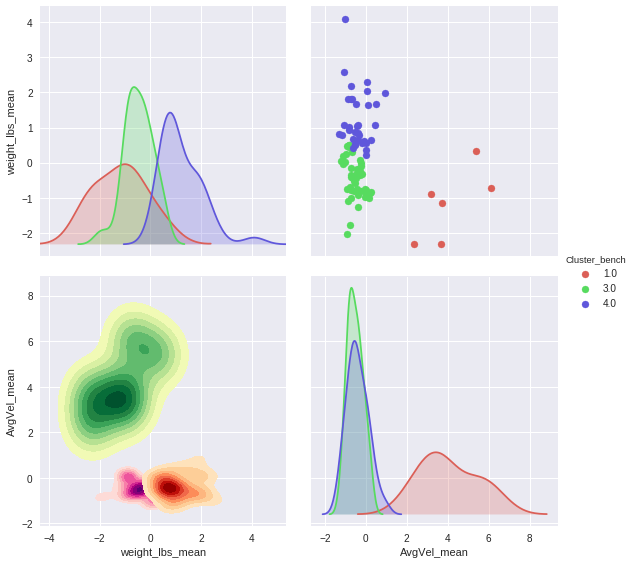

In [110]:
plot_exercise_grid(df_train_hc, 'bench', features_for_clustering, 'Cluster_bench')

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


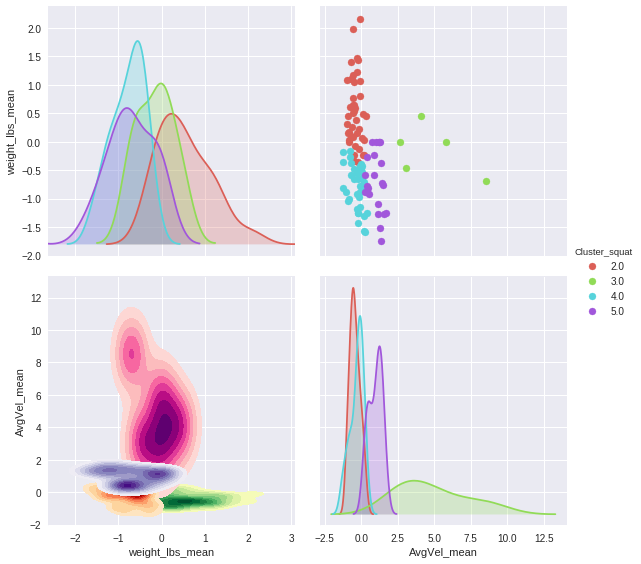

In [111]:
plot_exercise_grid(df_train_hc, 'squat', features_for_clustering, 'Cluster_squat')

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


ValueError: ignored

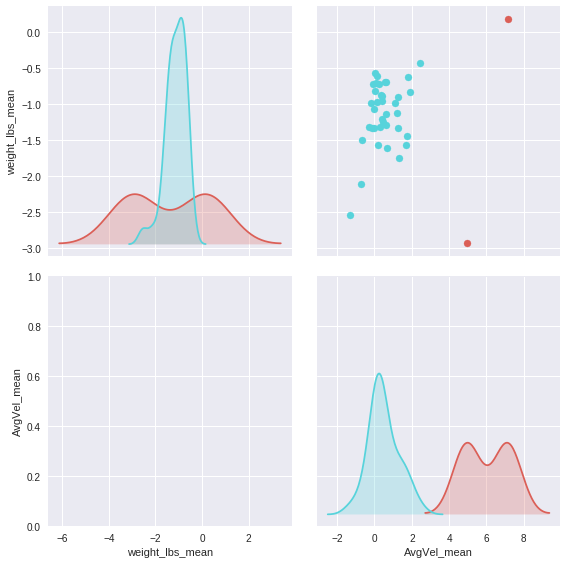

In [112]:
plot_exercise_grid(df_train_hc, 'deadlift', features_for_clustering, 'Cluster_deadlift')

### Checking outliers

In [0]:
bench_clusters[bench_clusters['Cluster']==2]

,userID,exercise_clean,Cluster
40,58aa55056ca711fcd8cb7b32,bench,2
181,59bfe74885ea1c6b42e4b25a,bench,2
256,5a1e278f05cbc9b8ef26ac64,bench,2
313,5ad3a71c880e87b3f32ddfa1,bench,2


In [0]:
deadlift_clusters[deadlift_clusters['Cluster']==1]

,userID,exercise_clean,Cluster
41,590528b56ca711fcd8cb7b78,deadlift,1
47,594faf336ca711fcd8cb7b96,deadlift,1
66,59adfbeb85ea1c6b42e4b1de,deadlift,1
197,5a03582305cbc9b8ef26ac4b,deadlift,1


In [0]:
get_descr(df_train[df_train['exercise_clean']=='bench'], features_for_clustering)

,weight_lbs_mean,AvgVel_mean,PeakVelLoc_mean,ROM_mean,PeakVel_mean,RepDur_mean,AvgVel_std,PeakVel_std
count,316.000000,323.000000,318.000000,323.000000,323.000000,3.180000e+02,321.000000,321.000000
mean,201.728705,0.463875,62.824031,343.091074,0.668281,9.255259e+05,0.138966,0.204373
std,73.378253,0.222805,15.916685,93.218150,0.359130,2.789467e+05,0.084399,0.142900
min,45.000000,0.164684,14.750000,186.149206,0.228535,3.297118e+05,0.006761,0.022886
25%,151.728111,0.305377,52.301505,290.082747,0.438289,7.174383e+05,0.074471,0.095332
50%,193.073878,0.418283,65.547075,331.333333,0.583310,9.202059e+05,0.119911,0.168825
75%,241.692948,0.553384,75.423396,381.502273,0.777615,1.117900e+06,0.185520,0.281133
max,606.270500,1.847519,92.333333,1298.333333,3.668828,1.897218e+06,0.578086,0.988118
pct_missing,2.170000,0.000000,1.550000,0.000000,0.000000,1.550000e+00,0.620000,0.620000
pct_zeros,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000


In [0]:
df[(df['userID']=='5ad3a71c880e87b3f32ddfa1') & (df['exercise_clean']=='bench')]

,_id,deleted,endTime,exercise,initialStartTime,metric,removed_set,rpe,setID,setNumber,...,TimeRepWait,SlowAllow,Backlight,MinAllow,PeakAccel,_merge,rpe_num,weight_lbs,exercise_clean,exercise_clean2
81419,46d2cd89-a088-4171-84f8-7c987318dea0,0.0,NaN,bench press,2018-04-15 21:38:06.887,lbs,0.0,< 5.5,46d2cd89-a088-4171-84f8-7c987318dea0,3.0,...,0.0,130000.0,10000.0,150000.0,253.22162,both,5.5,95.0,bench,bench other
83054,486a190e-72ff-4121-bc12-0ed995dc66c5,0.0,NaN,bench press,2018-04-15 21:42:58.788,lbs,0.0,6,486a190e-72ff-4121-bc12-0ed995dc66c5,6.0,...,0.0,130000.0,10000.0,150000.0,50.95581,both,6.0,195.0,bench,bench other
92902,510eb839-e45e-458f-9513-9e6f4307ed93,0.0,NaN,bench press,2018-04-15 21:45:55.497,lbs,0.0,7,510eb839-e45e-458f-9513-9e6f4307ed93,8.0,...,0.0,130000.0,10000.0,150000.0,99.14997,both,7.0,215.0,bench,bench other
93635,518bad99-f52b-4cf9-a9b8-7c94e20a2db5,0.0,NaN,bench press,2018-04-15 21:35:42.181,lbs,0.0,< 5.5,518bad99-f52b-4cf9-a9b8-7c94e20a2db5,2.0,...,0.0,130000.0,10000.0,150000.0,317.43283,both,5.5,65.0,bench,bench other
122484,6a094cd5-8fc6-4a43-acfb-d943d7f650bc,0.0,NaN,bench press,2018-04-20 03:17:53.367,lbs,0.0,7,6a094cd5-8fc6-4a43-acfb-d943d7f650bc,9.0,...,0.0,130000.0,10000.0,150000.0,84.28336,both,7.0,195.0,bench,bench other
152387,8498fcc8-0c12-4b26-b781-3dc6d0a2e6fb,0.0,NaN,bench press,2018-04-20 03:20:33.919,lbs,0.0,8,8498fcc8-0c12-4b26-b781-3dc6d0a2e6fb,11.0,...,0.0,130000.0,10000.0,150000.0,65.91347,both,8.0,215.0,bench,bench other
199692,ae9bad84-3051-4dc1-90df-bc38bf3599ff,0.0,NaN,bench press,2018-04-20 03:04:26.941,lbs,0.0,< 5.5,ae9bad84-3051-4dc1-90df-bc38bf3599ff,2.0,...,0.0,130000.0,10000.0,150000.0,291.29648,both,5.5,45.0,bench,bench other
206465,b4b0b43a-b1d9-423c-90b5-c2a200d16421,0.0,NaN,bench press,2018-04-15 21:40:23.142,lbs,0.0,< 5.5,b4b0b43a-b1d9-423c-90b5-c2a200d16421,4.0,...,0.0,130000.0,10000.0,150000.0,152.91692,both,5.5,145.0,bench,bench other
232334,caea628c-2a9e-43a3-b552-67f94efc99a7,0.0,NaN,bench press,2018-04-20 03:08:37.158,lbs,0.0,< 5.5,caea628c-2a9e-43a3-b552-67f94efc99a7,4.0,...,0.0,130000.0,10000.0,150000.0,293.30466,both,5.5,65.0,bench,bench other
233276,cbd091d5-1aa2-4c90-8fff-a7f299608542,0.0,NaN,bench press,2018-04-15 21:33:58.734,lbs,0.0,< 5.5,cbd091d5-1aa2-4c90-8fff-a7f299608542,1.0,...,0.0,130000.0,10000.0,150000.0,233.25110,both,5.5,45.0,bench,bench other


In [0]:
df_train[(df_train['userID']=='5a03582305cbc9b8ef26ac4b') & (df_train['exercise_clean']=='deadlift')]

,userID,exercise_clean,TtlRepNum,rpe_num_count,RepCount_count,weight_lbs_count,AvgVel_count,ROM_count,PeakVel_count,PeakVelLoc_count,...,PeakVelLoc_std,RepDur_mean,RepDur_amin,RepDur_amax,RepDur_std,PeakAccel_mean,PeakAccel_amin,PeakAccel_amax,PeakAccel_std,AvgRepsPerSet
1053,5a03582305cbc9b8ef26ac4b,deadlift,2,2,2,2,2,2,2,2,...,0.0,297043.0,278321.0,315765.0,26476.906315,978.86042,775.70544,1182.0154,287.304528,2.0


### Bench outliers:

#### Very high weight:

 - `58aa55056ca711fcd8cb7b32`
 
#### High velocity:

 - `59bfe74885ea1c6b42e4b25a`
 - `59adfbeb85ea1c6b42e4b1de`
 - `5ad3a71c880e87b3f32ddfa1`


### Deadlift outliers:

#### Very low/missing weight:

- `590528b56ca711fcd8cb7b78`

#### High velocity:

 - `594faf336ca711fcd8cb7b96`
 - `59adfbeb85ea1c6b42e4b1de`
 - `5a03582305cbc9b8ef26ac4b`

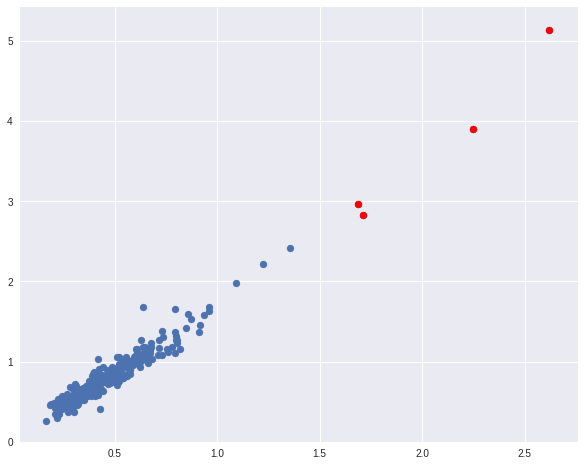

In [0]:
def plot_outliers(data, exercise, ids, features):
    
    data = data[data['exercise_clean']==exercise]
    
    plt.figure(figsize=(10, 8))
    
    plt.scatter(data[features[0]], data[features[1]])  # plot all points
    for user in ids:
        plt.scatter(data[data['userID']==user][features[0]], 
                    data[data['userID']==user][features[1]], 
                    c='r')  # plot interesting points in red again   
    plt.show()

ids = list(deadlift_clusters[deadlift_clusters["Cluster"]==1]['userID'])
plot_outliers(df_train, 'deadlift', ids, ['AvgVel_mean', 'PeakVel_mean'])

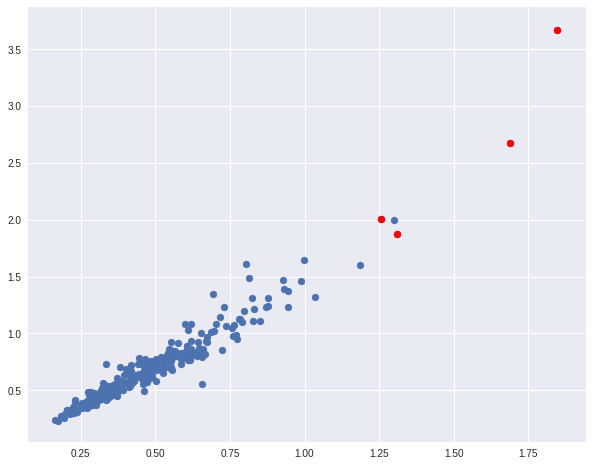

In [0]:
ids = list(bench_clusters[bench_clusters["Cluster"]==2]['userID'])
plot_outliers(df_train, 'bench', ids, ['AvgVel_mean', 'PeakVel_mean'])

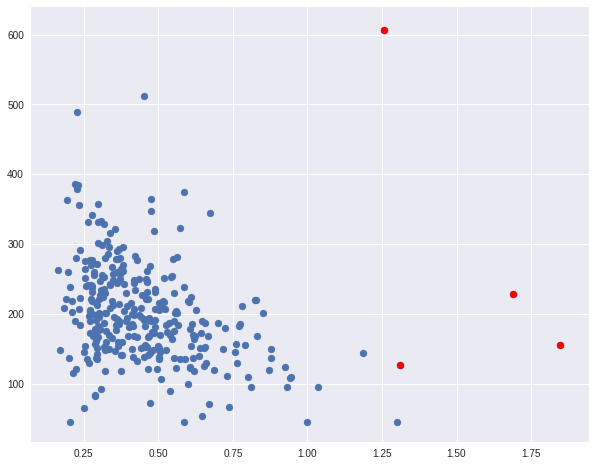

In [0]:
plot_outliers(df_train, 'bench', ids, ['AvgVel_mean', 'weight_lbs_mean'])

## PCA

In [0]:
def make_pca(data, n_comp):
    """Fits Principal Component Transformation on input data
    
    Args: 
        data: input dataset
        n_comp: int, number of components to keep
    
    Returns:
        PCA object
    """
    
    return PCA(n_components=n_comp).fit(data)


def plot_pca_contribution(data, exercise, n_min=2, n_max=8):
    """Fits PCA to input data and plots cumulative ratio 
    of explained variance by principal component
    
    Args:
        data: input dataset
        n: int, number of components to keep
    """
    
    data=data[data['exercise_clean']==exercise].drop(grouping_vars, axis=1)
    n_comp = data.shape[1]
    pca_explvar = make_pca(data, n_comp).explained_variance_ratio_
    pca_explvar_cum = np.insert(np.cumsum(pca_explvar), 0, 0)
    pc_min = pca_explvar_cum[n_min]
    pc_max = pca_explvar_cum[n_max]
    print("="*80)
    print(f"For {exercise} {n_min} PCs explain {pc_min*100:.1f}%", end = '')
    print(f" and {n_max} PCs explain {pc_max*100:.1f}%")
    plt.figure(figsize=(10, 5))
    plt.plot(pca_explvar_cum)
    alpha = 0.25
    plt.axvline(x=n_min, linestyle = '--', color = 'r', alpha = alpha, 
                label = f"{n_min} Principal Components")
    plt.axhline(y=pc_min, linestyle = '--', color = 'r', alpha = alpha)
    plt.axvline(x=n_max, linestyle = '--', color = 'g', alpha = alpha, 
                label = f"{n_max} Principal Components")
    plt.axhline(y=pc_max, linestyle = '--', color = 'g', alpha = alpha)
    plt.title(f"Cumulative Variance Explained by Principal Components for {exercise}",
             fontsize = 16)
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage of variance explained")
    plt.legend(fontsize = 14)
    plt.show()

For bench 2 PCs explain 69.1% and 4 PCs explain 90.2%


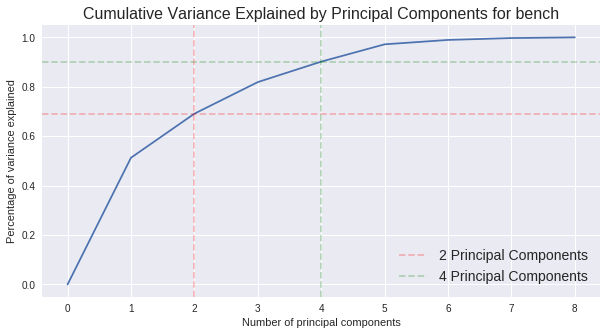

For squat 2 PCs explain 63.8% and 4 PCs explain 88.0%


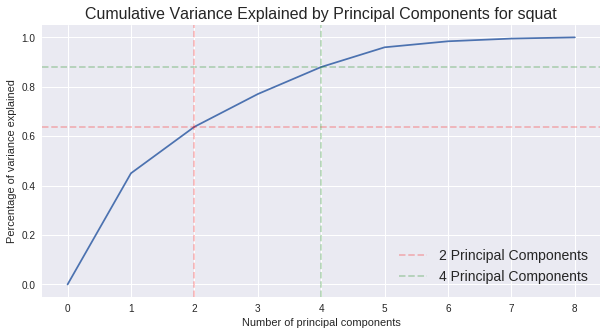

For deadlift 2 PCs explain 67.4% and 4 PCs explain 89.8%


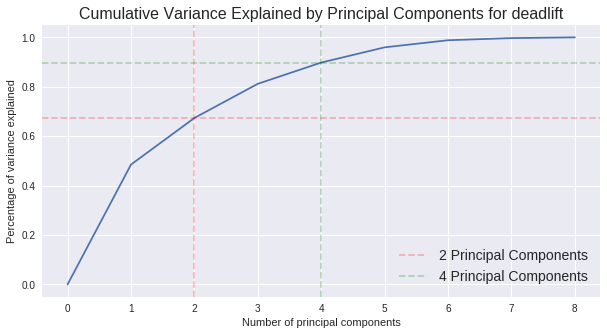

In [0]:
plot_pca_contribution(df_train_pr, 'bench', n_max=4)
plot_pca_contribution(df_train_pr, 'squat', n_max=4)
plot_pca_contribution(df_train_pr, 'deadlift', n_max=4)

In [0]:
def stack_pca_data(data, n_pca):
    
    data_out = np.empty(shape=(0,n_pca))
    for ex in exercises:
        pca_data = data[data['exercise_clean']==ex].drop(grouping_vars, axis=1)
        pca_data = make_pca(pca_data, n_pca).transform(pca_data)
        print(pca_data.shape)
        data_out = np.concatenate((data_out, pca_data), axis = 0)
    print(data_out.shape)
        
    return data_out

df_train_pca2 = stack_pca_data(df_train_pr, 2)
df_train_pca3 = stack_pca_data(df_train_pr, 3)

(323, 2)
(247, 2)
(311, 2)
(881, 2)
(323, 3)
(247, 3)
(311, 3)
(881, 3)


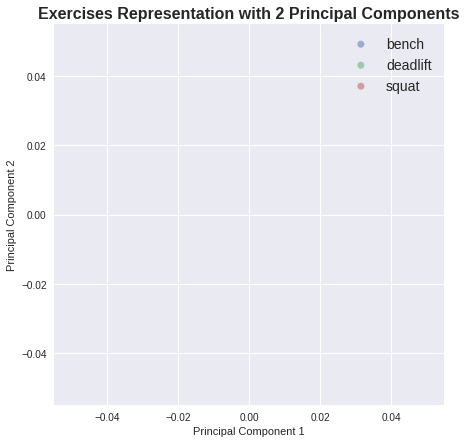

In [0]:
def make_2pca_plot(pca_data):
    """Plots PCA transformed data for two types of mushrooms
    
    Args:
        data: inpbut dataset
        labs: array of class labels (values = (0,1))
        n_comp: int,b number of principal components to keep
    """
    
    plt.figure(figsize=(7, 7))
    for ex in exercises:
        plt.scatter(pca_data[exercises==ex,0],pca_data[exercises==ex,1], 
                  alpha=0.5,  edgecolor='none', label = ex)
    plt.title(f"Exercises Representation with 2 Principal Components", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(fontsize=14)
    plt.show()
    
make_2pca_plot(df_train_pca2)

In [0]:
def make_3pca_plot(pca_data):
    """Plots PCA transformed data for two types of mushrooms
    
    Args:
        data: input dataset
        labs: array of class labels (values = (0,1))
        n_comp: int, number of principal components to keep
    """
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for ex in exercises:
        ax.scatter(pca_data[exercise_names==ex,0],
                 pca_data[exercise_names==ex,1], 
                 pca_data[exercise_names==ex,2],
                   label=ex,
                alpha = 0.4, s=100)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.view_init(azim=45)
    plt.legend(fontsize=14)
    plt.show()
    
make_3pca_plot(df_train_pca3)

## K Means

In [0]:
def make_kmeans(data, ncl):
    """Fits kmeans on input dataset
    
    Args:
        data: input dataset
        ncl: int, number of clusters
    
    Returns:
        KMeans object
    """  
    
    return KMeans(n_clusters = ncl, random_state = 22).fit(data)

In [0]:
check_frequency(bench_clusters["Cluster"])

In [0]:
ids = list(bench_clusters[bench_clusters["Cluster"]==2]['userID'])

In [0]:
df_train_pca2[:5]

## Hierarchical Clustering Example

All credit goes to:
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [0]:
features_for_clustering = ['ROM_mean', 'PeakVelLoc_std']
X = df_train_pr[df_train_pr['exercise_clean'] == 'bench'][features_for_clustering].values
X.shape

In [0]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [0]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
# Cophenetic Correlation Coefficient the closer the value is to 1, the better the clustering preserves the original distances
# Methods ‘centroid’, ‘median’ and ‘ward’ are correctly defined only if Euclidean pairwise metric is used
linkages = ['ward', 'single', 'complete', 'average', 'weighted', 'centroid', 'median']
distances = ['euclidean', 'cityblock', 'cosine', 'correlation']
for d in distances:
    for l in linkages:
        Z = linkage(X, l)
        c, coph_dists = cophenet(Z, pdist(X, d))
        print(d, l, round(c,2))
#         print(coph_dists.shape)

In [0]:
# but only ward gets a distinguished enough clustering
Z = linkage(X, 'ward')
c, coph_dists = cophenet(Z, pdist(X, 'euclidean'))
Z.shape

In [0]:
# [idx1, idx2, dist, sample_count]
Z[:9]

In [0]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1])  # plot all points
plt.scatter(X[[129, 190],0], X[[129, 190],1], c='r')  # plot interesting points in red again
plt.scatter(X[[17, 198],0], X[[129, 190],1], c='orange')  # plot interesting points in red again
plt.show()

In [0]:
# distances at the last 4 merges:
Z[-10:,2]

In [0]:
max_d = 0.4*max(Z[:,2])
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=10.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    color_threshold = max_d,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.axhline(y=max_d, c='k', ls='--')
plt.show()

In [0]:
# visualizing distances
plt.plot(Z[:,2])

In [0]:
clusters = pd.Series(fcluster(Z, max_d, criterion='distance'))
check_frequency(clusters)

In [0]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()